In [276]:
# for data manipulation
import pandas as pd
import numpy as np
# for plotting
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go # note that github wont be able to display these plots because they are interactive
# for some processing
import math
from datetime import datetime, timedelta

In [277]:
folder = "kaggle/input/"
df_train = pd.read_csv(folder + "train.csv")
df_train = df_train.drop(columns = ["CustomerID", "Coverage", "Education", "Employment Status", "Marital Status", "Policy Type", "Policy", "Sales Channel", "Vehicle Size"])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          7290 non-null   object 
 1   Customer Lifetime Value        7290 non-null   float64
 2   Response                       7290 non-null   object 
 3   Coverage Index                 7290 non-null   int64  
 4   Education Index                7290 non-null   int64  
 5   Effective To Date              7290 non-null   object 
 6   Employment Status Index        7290 non-null   int64  
 7   Gender                         7290 non-null   object 
 8   Income                         7290 non-null   int64  
 9   Marital Status Index           7290 non-null   int64  
 10  Months Since Last Claim        7290 non-null   int64  
 11  Months Since Policy Inception  7290 non-null   int64  
 12  Number of Open Complaints      7290 non-null   i

In [278]:
def pre_process(df):
  # State
  unique_states = df["State"].unique()
  dict_states = {}
  for i in range(len(unique_states)):
    dict_states[unique_states[i]] = i
  df["State"] = df["State"].apply(lambda x: dict_states[x])
  
  # Response
  # note that resonse should be either yes or no
  df["Response"] = df["Response"].apply(lambda x: 1 if x == "Yes" else 0)

  # Effective To Date
  df["Effective To Date"] = pd.to_datetime(df["Effective To Date"])
  today = pd.Timestamp.today()
  df["Effective Days"] = (today - df["Effective To Date"]).dt.days
  # drop the date columns
  df.drop("Effective To Date", axis = 1, inplace=True)
  # Gender
  df["Gender"] = df["Gender"].apply(lambda x: 1 if x == "M" else 0)


In [279]:
pre_process(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          7290 non-null   int64  
 1   Customer Lifetime Value        7290 non-null   float64
 2   Response                       7290 non-null   int64  
 3   Coverage Index                 7290 non-null   int64  
 4   Education Index                7290 non-null   int64  
 5   Employment Status Index        7290 non-null   int64  
 6   Gender                         7290 non-null   int64  
 7   Income                         7290 non-null   int64  
 8   Marital Status Index           7290 non-null   int64  
 9   Months Since Last Claim        7290 non-null   int64  
 10  Months Since Policy Inception  7290 non-null   int64  
 11  Number of Open Complaints      7290 non-null   int64  
 12  Number of Policies             7290 non-null   i

In [280]:
# def process_state(df):
#   unique_states = df["State"].unique()
#   dict_states = {}
#   for i in range(len(unique_states)):
#     dict_states[unique_states[i]] = i
#   df["State"] = df["State"].apply(lambda x: dict_states[x])
# process_state(df_train)

In [281]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample

In [282]:
def balanace(df):
  df_majority = df[df["Claim over 1k"] == 0]
  df_minority = df[df["Claim over 1k"] == 1]
  # Upsample minority class
  df_minority_upsampled = resample(df_minority,
                                    replace=True,  # Sample with replacement
                                    n_samples=len(df_majority),  # Match the majority class
                                    random_state=42)  # Reproducible results

  # Combine majority class with upsampled minority class
  df_balanced = pd.concat([df_majority, df_minority_upsampled])

  from imblearn.over_sampling import SMOTE

  X = df_balanced.drop(columns=['Claim over 1k'])  # Features
  y = df_balanced['Claim over 1k']  # Target

  smote = SMOTE(random_state=42)
  X_resampled, y_resampled = smote.fit_resample(X, y)
  return X_resampled, y_resampled

In [283]:
# X = df_train.drop("Claim over 1k", axis = 1)
# y = df_train["Claim over 1k"]

X_resampled, y_resampled = balanace(df_train)

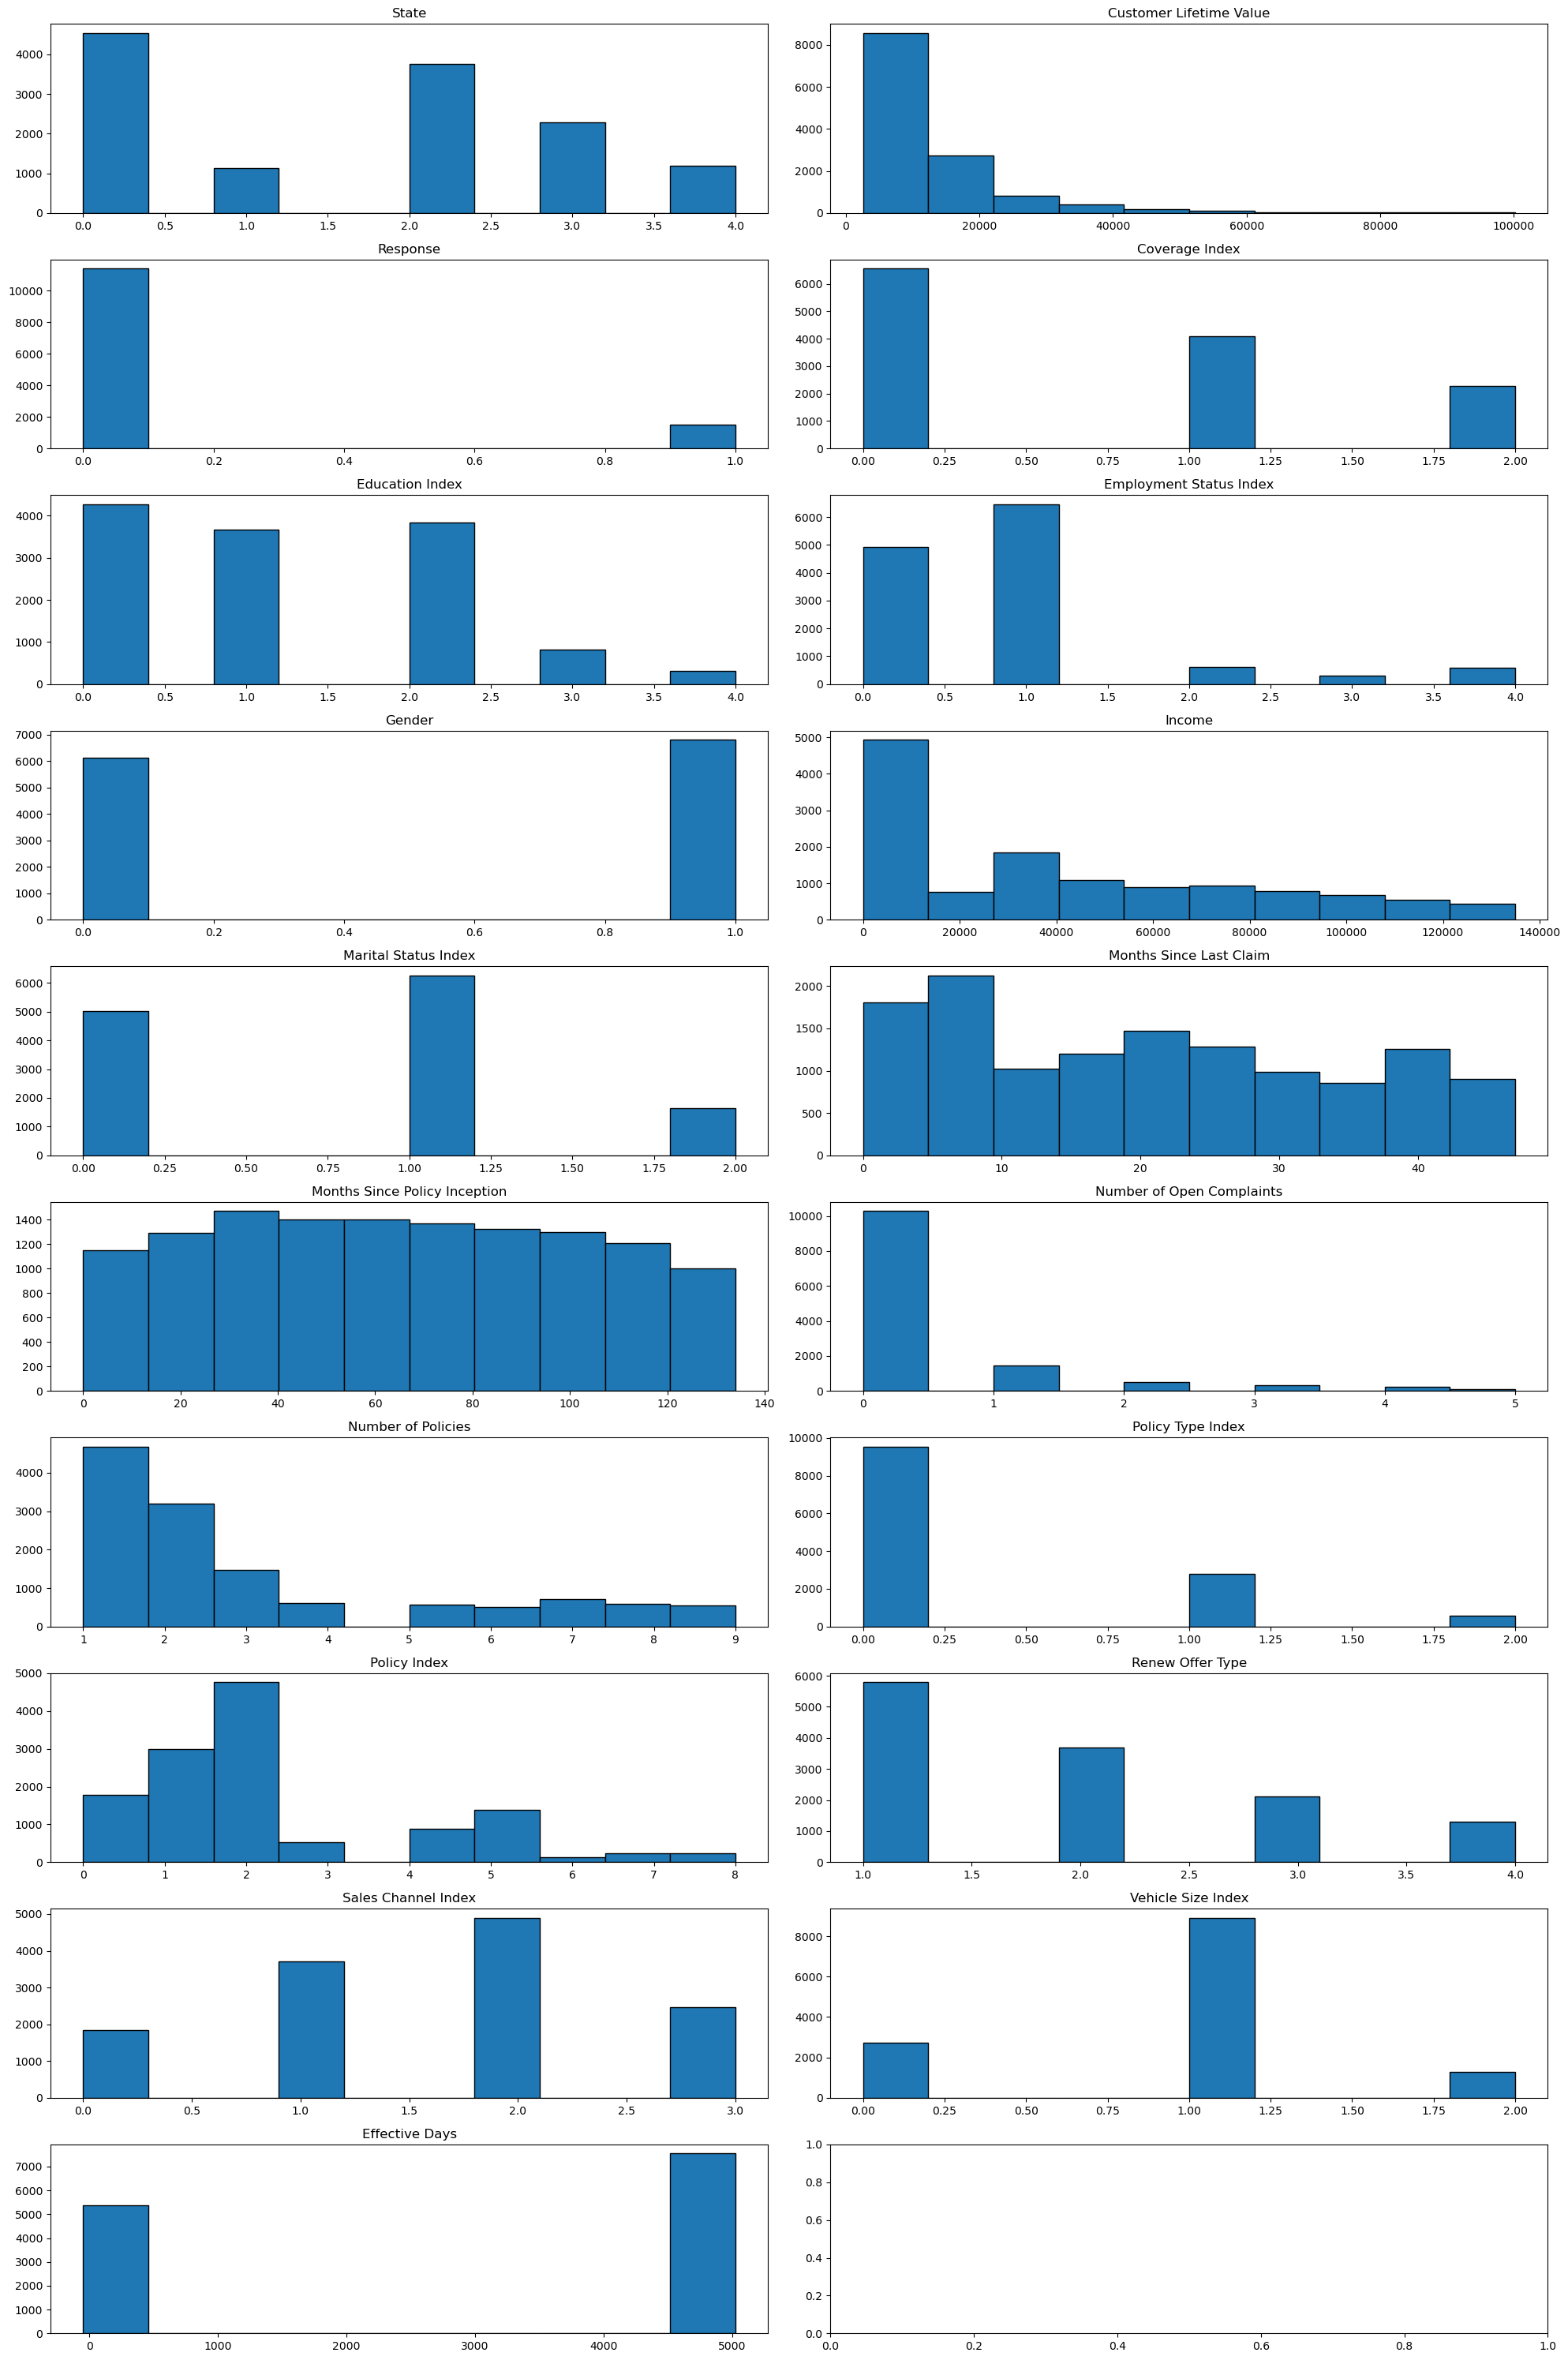

In [284]:
import math

def plot_np(X, names, ax):
  m, n = X.shape
  for index in range(n):
    col = X[:, index]
    i, j = index // 2, index % 2
    ax[i, j].hist(col, bins=10, edgecolor="black")
    ax[i, j].set_title(f"{names[index]}")

def plot_df(df):
  X = np.array(df)
  m, n = X.shape
  number_of_row = math.ceil(n / 2)
  # plot subplots
  fig, ax = plt.subplots(number_of_row, 2, figsize=(20,30))
  plot_np(X, df.columns, ax)
  # plot
  plt.tight_layout()
  plt.show()
plot_df(X_resampled)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [286]:
def neural_network():
  model = MLPClassifier(hidden_layer_sizes=(16, 8, 2), max_iter=500, random_state=42)
  model.fit(X_train_scaled, y_train)

  # Predict the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)
  
  # Calculate accuracy and F1 score
  print(f"Accuracy: {accuracy}")
  print("Confusion Matrix:")
  print(conf_matrix)
  print("Classification Report:")
  print(class_report)
  f1 = f1_score(y_test, y_pred)
  print(f1)
neural_network()

Accuracy: 0.9027562712914214
Confusion Matrix:
[[1404  202]
 [ 112 1511]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1606
           1       0.88      0.93      0.91      1623

    accuracy                           0.90      3229
   macro avg       0.90      0.90      0.90      3229
weighted avg       0.90      0.90      0.90      3229

0.9058752997601919


In [287]:
def logistics_regression():
  # Initialize Logistic Regression model
  log_reg = LogisticRegression()

  # Train the model on the training data
  log_reg.fit(X_train_scaled, y_train)

  # Make predictions on the test data
  y_pred = log_reg.predict(X_test_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)

  print(f"Accuracy: {accuracy}")
  print("Confusion Matrix:")
  print(conf_matrix)
  print("Classification Report:")
  print(class_report)
  f1 = f1_score(y_test, y_pred)
  print(f1)
logistics_regression()


Accuracy: 0.7367606069990709
Confusion Matrix:
[[1175  431]
 [ 419 1204]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1606
           1       0.74      0.74      0.74      1623

    accuracy                           0.74      3229
   macro avg       0.74      0.74      0.74      3229
weighted avg       0.74      0.74      0.74      3229

0.7391037446286065


In [288]:

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=50, criterion="gini", random_state=42, class_weight = 'balanced', max_depth=13, min_samples_split=10)

# Train the model on the training data
# Note that random forest is a decision tree (if-else statment on each node), so the data does not have to be scaled
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
f1 = f1_score(y_test, y_pred)
print(f1)


old_X = df_train.drop("Claim over 1k", axis=1)
old_y = df_train["Claim over 1k"]
old_X_train, old_X_test, old_y_train, old_y_test = train_test_split(old_X, old_y, test_size = 0.25, random_state = 42)
old_y_pred = rf_classifier.predict(old_X_test)
# Evaluate the model
old_accuracy = accuracy_score(old_y_test, old_y_pred)
old_conf_matrix = confusion_matrix(old_y_test, old_y_pred)
old_class_report = classification_report(old_y_test, old_y_pred)

print("\nResults According to old Dataset (Before Oversampling)\n")
# Print the results
print(f"Accuracy: {old_accuracy}")
print("Confusion Matrix:")
print(old_conf_matrix)
print("Classification Report:")
print(old_class_report)
old_f1 = f1_score(old_y_test, old_y_pred)
print(old_f1)

Accuracy: 0.9646949519975224
Confusion Matrix:
[[1503  103]
 [  11 1612]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1606
           1       0.94      0.99      0.97      1623

    accuracy                           0.96      3229
   macro avg       0.97      0.96      0.96      3229
weighted avg       0.97      0.96      0.96      3229

0.9658478130617136

Results According to old Dataset (Before Oversampling)

Accuracy: 0.9621503017004936
Confusion Matrix:
[[1561   66]
 [   3  193]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1627
           1       0.75      0.98      0.85       196

    accuracy                           0.96      1823
   macro avg       0.87      0.97      0.91      1823
weighted avg       0.97      0.96      0.96      1823

0.8483516483516483


In [289]:
df_test = pd.read_csv(folder + "test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     1844 non-null   object 
 1   State                          1844 non-null   object 
 2   Customer Lifetime Value        1844 non-null   float64
 3   Response                       1844 non-null   object 
 4   Coverage                       1844 non-null   object 
 5   Coverage Index                 1844 non-null   int64  
 6   Education                      1844 non-null   object 
 7   Education Index                1844 non-null   int64  
 8   Effective To Date              1844 non-null   object 
 9   Employment Status              1844 non-null   object 
 10  Employment Status Index        1844 non-null   int64  
 11  Gender                         1844 non-null   object 
 12  Income                         1844 non-null   i

In [290]:
df_to_run_test = df_test.drop(columns = ["CustomerID", "Coverage", "Education", "Employment Status", "Marital Status", "Policy Type", "Policy", "Sales Channel", "Vehicle Size"])
pre_process(df_to_run_test)
X_test_to_run_test = df_to_run_test
y_test_pred = rf_classifier.predict(X_test_to_run_test)

In [291]:
print(y_test_pred)
customer_ID = np.array(df_test["CustomerID"])
print(customer_ID)
result = np.column_stack((customer_ID, y_test_pred))
print(result)

[0 0 0 ... 0 0 0]
['WB38524' 'QP80741' 'WP41146' ... 'EZ43738' 'PJ36160' 'IC80537']
[['WB38524' 0]
 ['QP80741' 0]
 ['WP41146' 0]
 ...
 ['EZ43738' 0]
 ['PJ36160' 0]
 ['IC80537' 0]]


In [292]:
df_run_test_ouput = pd.DataFrame(result)
df_run_test_ouput.rename(columns={0: "CustomerID", 1: "Claim over 1k"}, inplace=True)
df_run_test_ouput

,CustomerID,Claim over 1k
0,WB38524,0
1,QP80741,0
2,WP41146,0
3,KR62797,0
4,VE55982,0
...,...,...
1839,DK92504,1
1840,YD28431,0
1841,EZ43738,0
1842,PJ36160,0


In [293]:
df_run_test_ouput["Claim over 1k"].value_counts()

Claim over 1k
0    1608
1     236
Name: count, dtype: int64

In [294]:
df_run_test_ouput.to_csv('submission.csv', index=False)

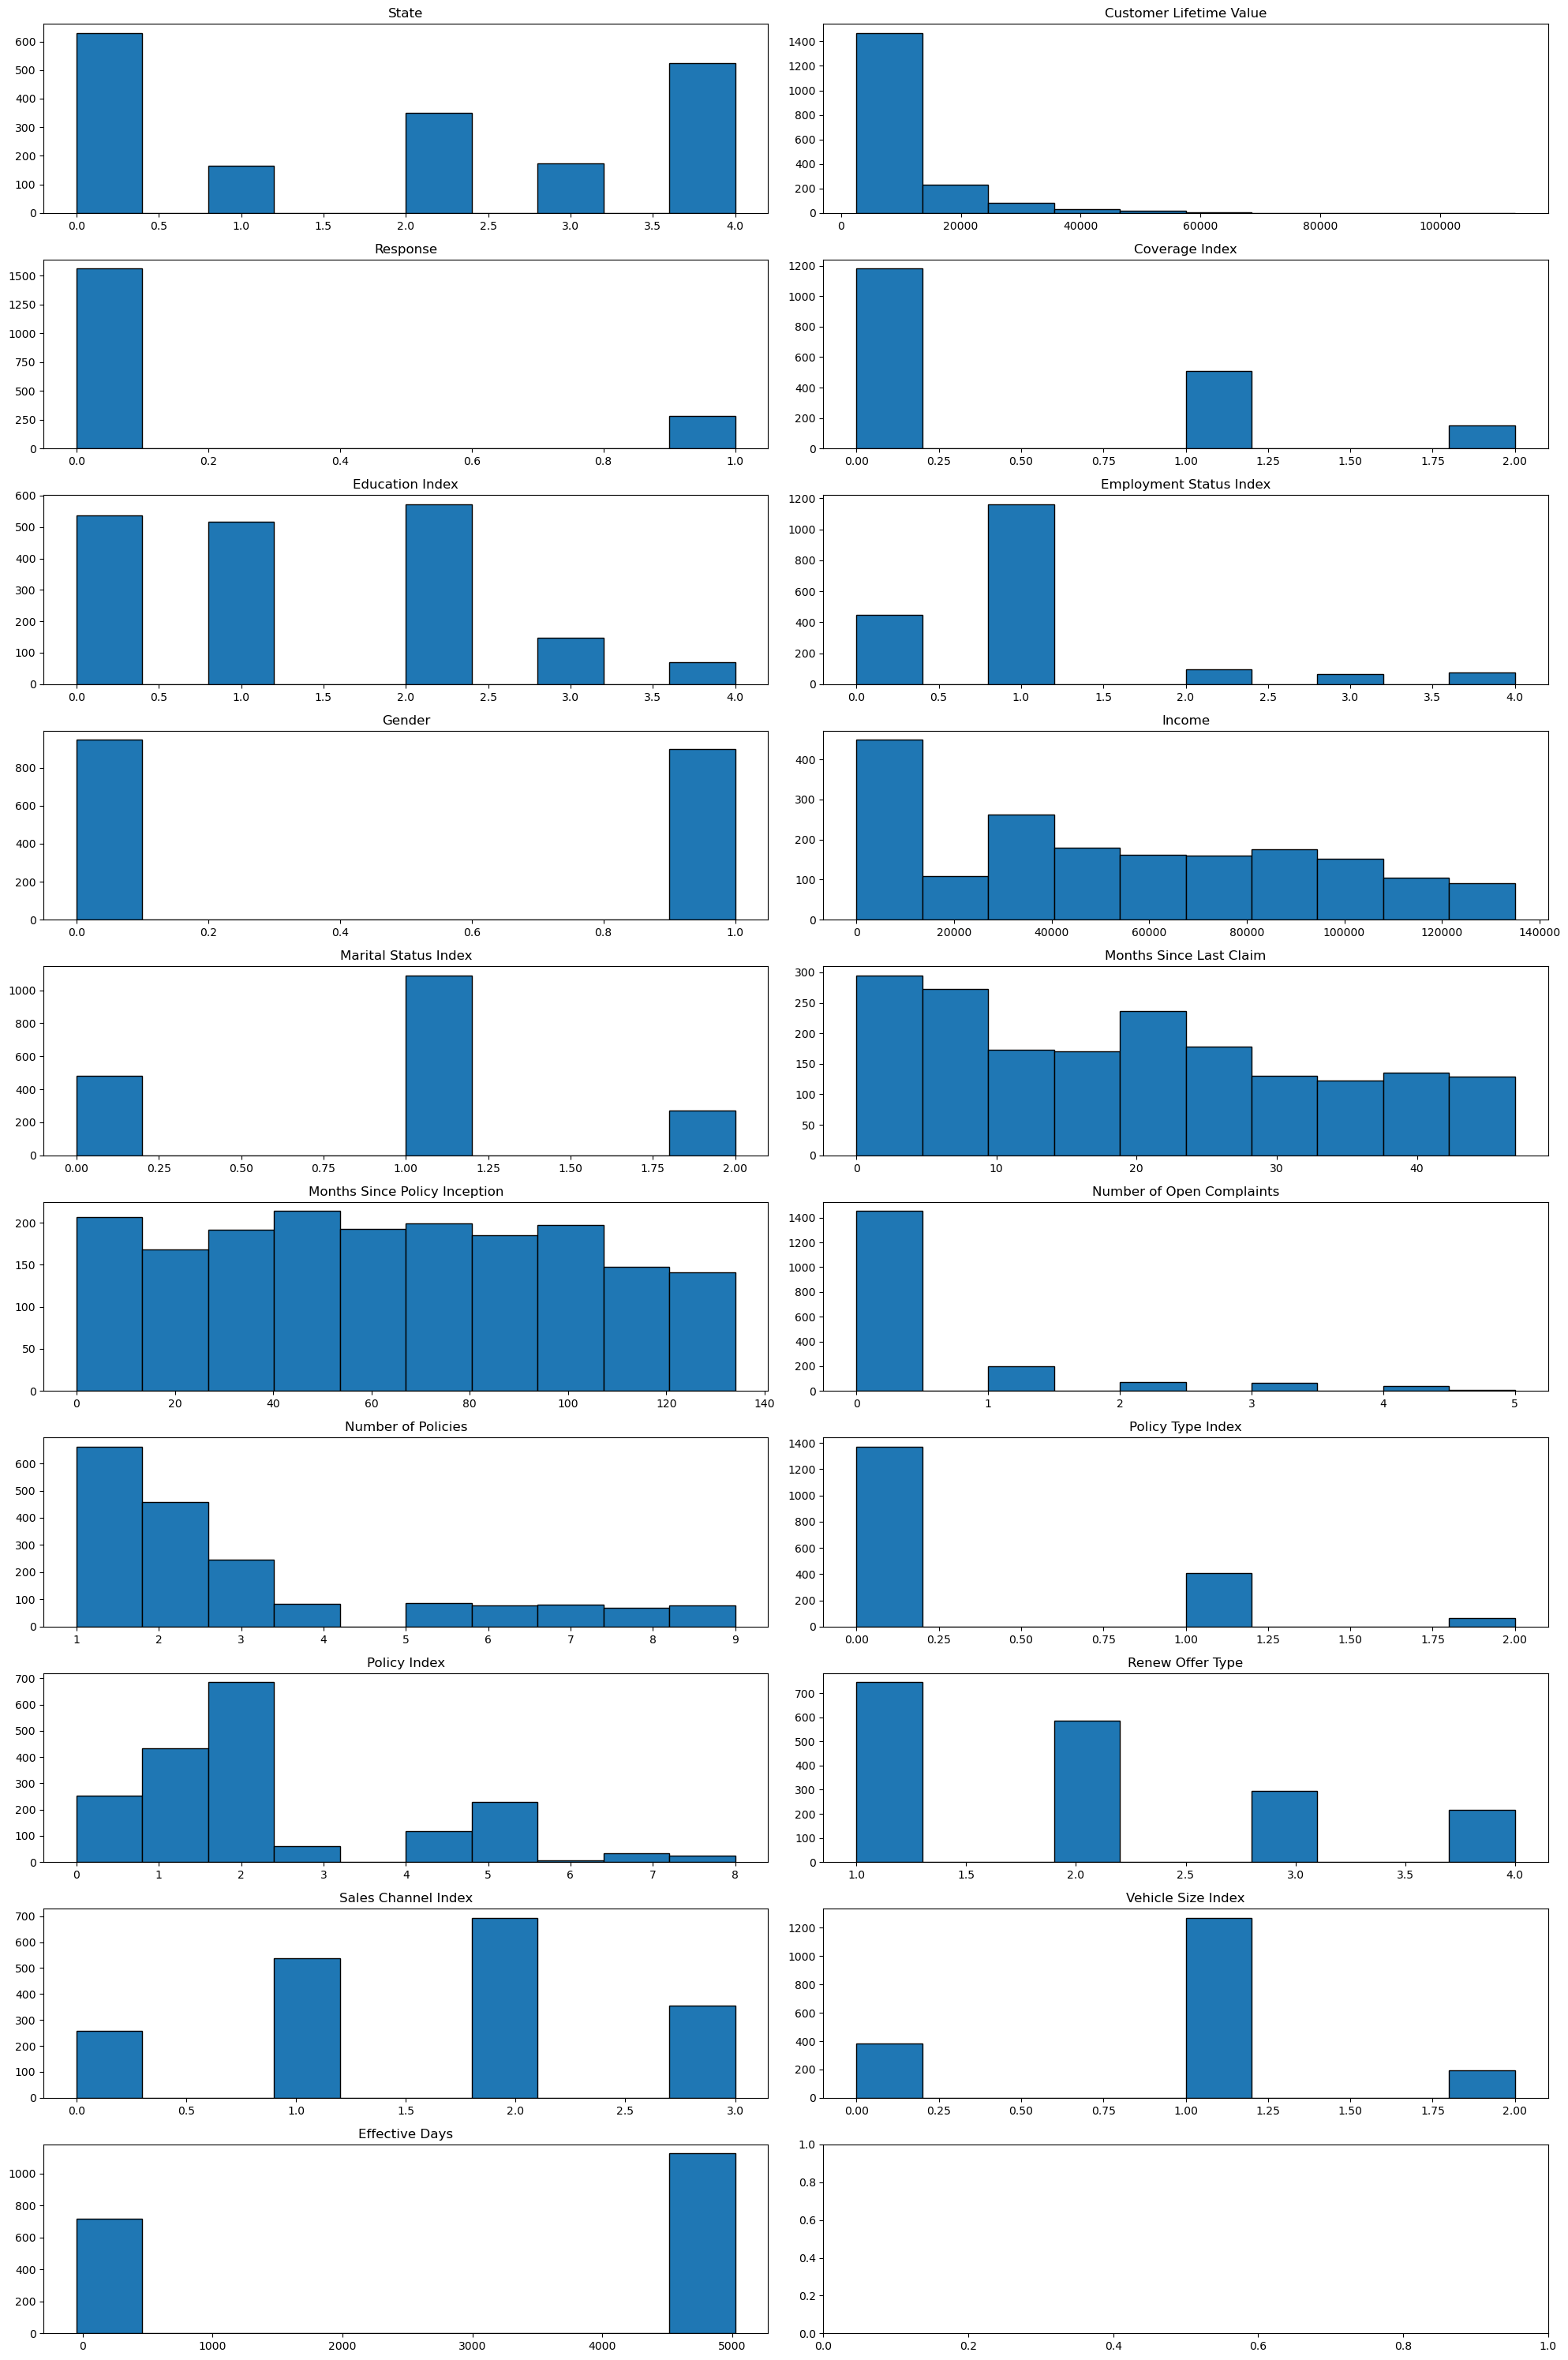

In [295]:
plot_df(df_to_run_test)